## Smoking model

In [1]:
import numpy as np

# ---------------------
# 1. MODEL PARAMETERS
# ---------------------
T = 25             # Number of periods
delta_S = 0.5         # Depreciation factor for S
y = 10                # Income (or similar constant)
p = 1                 # Price or cost parameter for smoking

# Parameters for the utility function
a_sigma  = -0.5      # Increased weight on sigma effects (disease status)
a_0      = 1
a_c      = 0.6
a_sb     = 0.21
a_bsigma = -0.4
beta     = 0.98       # Increase discount factor so future matters more
a_b = 0.05
# penalty = 1
# ---------------------
# 2. GRIDS
# ---------------------
# Grid for S (continuous, positive)
S_grid = np.linspace(0, 50, 50)
nS = len(S_grid)

# Grid for sigma (binary)
sigma_values = [0, 1]
nSigma = len(sigma_values)

# Grid for lambda (beliefs)
lambda_grid = np.linspace(-100, 100, 50)
nLambda = len(lambda_grid)

# ---------------------
# 3. CHOICE SET
# ---------------------
b_choices = [0, 1]  # e.g. 0 = no smoking, 1 = smoking

# ---------------------
# 4. UTILITY FUNCTION
# ---------------------
def utility(S, sigma, b):
    """
    Example utility function.
    """
    return np.exp(a_sigma * sigma) * (a_0 + (y - p * b)**a_c * (1+b) ** a_b * (1 + S * b)**a_sb * (1 + sigma * b)**a_bsigma)
# def utility(S, sigma, b):
#     return (y-b*p) ** a_c * (1+b)**(1-a_c) - penalty * sigma
# ---------------------
# 5. TRANSITION FUNCTIONS
# ---------------------
def transition_S(S, b):
    """
    Transition for S: S evolves depending on b.
    """
    if b == 1:
        new_S = (1 - delta_S) * S + 1
    else:
        new_S = (1 - delta_S) * S
    # Keep S within grid bounds.
    new_S = max(new_S, S_grid[0])
    new_S = min(new_S, S_grid[-1])
    return new_S

# def pi_of_S(S):
#     """
#     Logistic-like function: pi(S) = 1 / (1 + exp(-S)).
#     """
#     return 1.0 / (1.0 + np.exp(-S))

def pi_of_S(S, k=0.1, S0=S_grid[-1]/2):
    """
    A logistic function that maps S to (0,1) such that:
      - If S << S0, then pi(S) is near 0.
      - If S >> S0, then pi(S) is near 1.
      
    Parameters:
      k: controls the steepness of the curve.
      S0: the value of S at which pi(S)=0.5.
    """
    
    return 1.0 / (1.0 + np.exp(-k * (S - S0)))


def transition_lambda(lambda_val, S, sigma_lagged, sigma_current):
    """
    Update beliefs lambda according to:
      if sigma_lagged == 0:
          if sigma_current == 1:
              lambda_new = lambda + log(pi(S)/pi(0))
          else:
              lambda_new = lambda + log((1-pi(S))/(1-pi(0)))
      else:
          lambda_new = lambda
    """
    if sigma_lagged == 0:
        if sigma_current == 1:
            new_lambda = lambda_val + np.log(pi_of_S(S) / pi_of_S(0))
        else:
            new_lambda = lambda_val + np.log((1 - pi_of_S(S)) / (1 - pi_of_S(0)))
    else:
        new_lambda = lambda_val
    return new_lambda

def prob_sigma_next_is_one(sigma_current, lambda_val, S):
    """
    Returns the probability that sigma_{t+1} = 1.
    For sigma_current=1, assume sigma remains 1.
    For sigma_current=0, use a logistic-based formula incorporating lambda.
    """
    if sigma_current == 1:
        return 1.0
    else:
        # Example formulation: 
        # P(sigma_{t+1}=1 | sigma_t=0, lambda, S) = [pi(S)*exp(lambda) + pi(0)] / [1+exp(lambda)]
        if S==0: num = pi_of_S(S) * np.exp(lambda_val) + 0
        else: num = pi_of_S(S) * np.exp(lambda_val) + pi_of_S(0)
        den = 1.0 + np.exp(lambda_val)
        output = num / den
        assert output <= 1 and output >=0, "det er ikke en sandsynlighed"
        return output

# ---------------------
# 6. VALUE FUNCTION & POLICY ARRAYS
# ---------------------
# Four-dimensional arrays: dimensions (T, nS, nSigma, nLambda)
V = np.zeros((T, nS, nSigma, nLambda))
Policy = np.zeros((T, nS, nSigma, nLambda), dtype=int)

# ---------------------
# 7. BACKWARD INDUCTION
# ---------------------
# --- Last Period (t = T-1): Agent maximizes immediate utility ---
t = T - 1
for i, S_val in enumerate(S_grid):
    for j, sigma_val in enumerate(sigma_values):
        for k, lambda_val in enumerate(lambda_grid):
            best_value = -np.inf
            best_choice = 0
            for b in b_choices:
                u = utility(S_val, sigma_val, b)
                if u > best_value:
                    best_value = u
                    best_choice = b
            V[t, i, j, k] = best_value
            Policy[t, i, j, k] = best_choice

# --- Earlier Periods: t = T-2 down to 0 ---
for t in reversed(range(T - 1)):
    for i, S_val in enumerate(S_grid):
        for j, sigma_val in enumerate(sigma_values):
            for k, lambda_val in enumerate(lambda_grid):
                best_value = -np.inf
                best_choice = 0
                for b in b_choices:
                    # Immediate utility
                    u = utility(S_val, sigma_val, b)
                    
                    # Next state for S (deterministic)
                    S_next = transition_S(S_val, b)
                    i_next = np.argmin(np.abs(S_grid - S_next))
                    
                    # Probability that sigma_{t+1}=1 (if current sigma==0)
                    p1 = prob_sigma_next_is_one(sigma_val, lambda_val, S_val)
                    
                    # Determine lambda transition for both possible sigma outcomes.
                    # For sigma_{t+1} = 1:
                    lambda_next_1 = transition_lambda(lambda_val, S_val, sigma_val, 1)
                    k_next_1 = np.argmin(np.abs(lambda_grid - lambda_next_1))
                    # For sigma_{t+1} = 0:
                    lambda_next_0 = transition_lambda(lambda_val, S_val, sigma_val, 0)
                    k_next_0 = np.argmin(np.abs(lambda_grid - lambda_next_0))
                    
                    # Next sigma: if sigma already 1, remains 1; if 0, can be 1 with probability p1, 0 with 1-p1.
                    # For sigma_{t+1}=1, we assign j_next_1 = 1, and for sigma_{t+1}=0, j_next_0 = 0.
                    j_next_1 = 1
                    j_next_0 = 0
                    
                    # Expected continuation value.
                    cont_val = (p1 * V[t+1, i_next, j_next_1, k_next_1] +
                                (1 - p1) * V[t+1, i_next, j_next_0, k_next_0])
                    
                    total_value = u + beta * cont_val
                    # print(f'b: {b} and t: {t} and lambda: {k} we have that total value is {total_value}')
                    if total_value > best_value:
                        best_value = total_value
                        best_choice = b

                V[t, i, j, k] = best_value
                Policy[t, i, j, k] = best_choice

# ---------------------
# 8. EXAMPLE USAGE
# ---------------------
# Retrieve the optimal decision and value at time t=0 for a given state:
t0 = 0
S_example = 0.0
sigma_example = 0
lambda_example = 0

# Find the nearest indices in the grids
i_example = np.argmin(np.abs(S_grid - S_example))
j_example = sigma_values.index(sigma_example)
k_example = np.argmin(np.abs(lambda_grid - lambda_example))

optimal_decision = Policy[t0, i_example, j_example, k_example]
optimal_value    = V[t0, i_example, j_example, k_example]

print(f"At t={t0}, S={S_example:.2f}, sigma={sigma_example}, lambda={lambda_example:.2f}:")
print(f"  Optimal decision b = {optimal_decision}")
print(f"  Value function     = {optimal_value:.4f}")


At t=0, S=0.00, sigma=0, lambda=0.00:
  Optimal decision b = 0
  Value function     = 95.7669


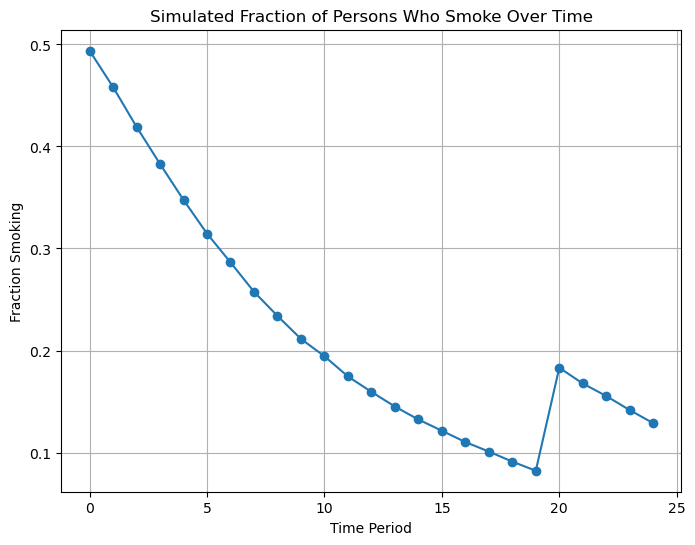

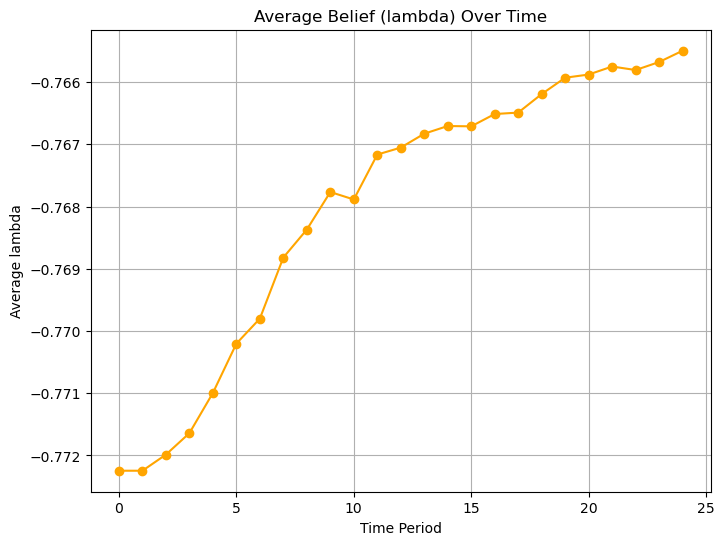

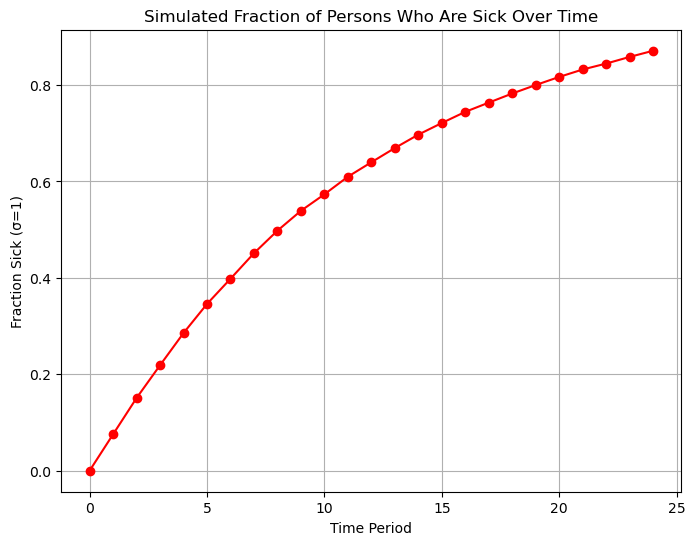

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
P = 1000  # Number of simulated persons

# Arrays to store simulated state trajectories
S_sim = np.zeros((T, P))
sigma_sim = np.zeros((T, P), dtype=int)
lambda_sim = np.zeros((T, P))
b_sim = np.zeros((T, P), dtype=int)  # Decision at each period

# Initialize individuals: randomly sample initial S and lambda; sigma set to 0.
np.random.seed(1)
S_sim[0, :] = 0 # np.random.choice(S_grid, size=P)
sigma_sim[0, :] = 0
lambda_sim[0, :] = np.random.choice(lambda_grid, size=P)

# Simulate forward in time.
for t in range(T - 1):
    for person in range(P):
        # Current state
        S_val = S_sim[t, person]
        sigma_val = sigma_sim[t, person]
        lambda_val = lambda_sim[t, person]
        
        # Find nearest grid indices.
        i_idx = np.argmin(np.abs(S_grid - S_val))
        j_idx = sigma_values.index(sigma_val)
        k_idx = np.argmin(np.abs(lambda_grid - lambda_val))
        
        # Retrieve optimal decision from the pre-computed policy.
        b_decision = Policy[t, i_idx, j_idx, k_idx]
        b_sim[t, person] = b_decision
        
        # Update state for S.
        S_next = transition_S(S_val, b_decision)
        
        # Update sigma: if sigma is already 1, it remains 1; if 0, sample based on probability.
        if sigma_val == 0:
            p1 = pi_of_S(S_val) 
        else: 
            p1 = 1
        rand = np.random.rand()
        if rand < p1: sigma_next = 1; #print(f'cond ={rand < p1}, with {rand} < {p1} ')
        else: sigma_next = 0
        
        # Update lambda based on the belief update.
        lambda_next = transition_lambda(lambda_val, S_val, sigma_val, sigma_next)
        
        # Store new states for t+1.
        S_sim[t+1, person] = S_next
        sigma_sim[t+1, person] = sigma_next
        lambda_sim[t+1, person] = lambda_next

# Store the final period's decision as well.
for person in range(P):
    i_idx = np.argmin(np.abs(S_grid - S_sim[T-1, person]))
    j_idx = sigma_values.index(sigma_sim[T-1, person])
    k_idx = np.argmin(np.abs(lambda_grid - lambda_sim[T-1, person]))
    b_sim[T-1, person] = Policy[T-1, i_idx, j_idx, k_idx]

# ---------------------
# 8. PLOTTING SIMULATION RESULTS
# ---------------------
# For example, plot the fraction of persons smoking over time.
fraction_smoking = np.mean(b_sim, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(range(T), fraction_smoking, marker='o')
plt.xlabel('Time Period')
plt.ylabel('Fraction Smoking')
plt.title('Simulated Fraction of Persons Who Smoke Over Time')
plt.grid(True)
plt.show()

# Also, we can plot average lambda over time.
avg_lambda = np.mean(lambda_sim, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(range(T), avg_lambda, marker='o', color='orange')
plt.xlabel('Time Period')
plt.ylabel('Average lambda')
plt.title('Average Belief (lambda) Over Time')
plt.grid(True)
plt.show()

# Compute fraction of sick persons (sigma == 1) over time.
fraction_sick = np.mean(sigma_sim, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(range(T), fraction_sick, marker='o', color='red')
plt.xlabel('Time Period')
plt.ylabel('Fraction Sick (σ=1)')
plt.title('Simulated Fraction of Persons Who Are Sick Over Time')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def pi_of_S(S, k=0.0, S0=50):
    """
    A logistic function that maps S to (0,1) such that:
      - If S << S0, then pi(S) is near 0.
      - If S >> S0, then pi(S) is near 1.
      
    Parameters:
      k: controls the steepness of the curve.
      S0: the value of S at which pi(S)=0.5.
    """
    return 1.0 / (1.0 + np.exp(-k * (S - S0)))

# Define the S values over the linspace from 0 to 50
S_values = np.linspace(0, 50, 500)

# Define different k values
k_values = [0.01, 0.05, 0.1, 0.2]

plt.figure(figsize=(8, 6))
for k in k_values:
    plt.plot(S_values, pi_of_S(S_values, k=k,S0=25), label=f'k = {k}')

plt.title('Logistic Function pi(S) for Different Values of k')
plt.xlabel('S')
plt.ylabel('pi(S)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def utility(S, sigma, b):
    """
    Example utility function.
    """
    return np.exp(a_sigma * sigma) * (a_0 + (y - p * b)**a_c * (1+b) ** a_b * (1 + S * b)**a_sb * (1 + sigma * b)**a_bsigma)

for a in [-1000,-5,0,3]:
    a_sigma=a
    print(utility(0,1,1) <= utility(0,1,0))


a_sigma = -10000
a_sigma = -5000
a_sigma = -2000


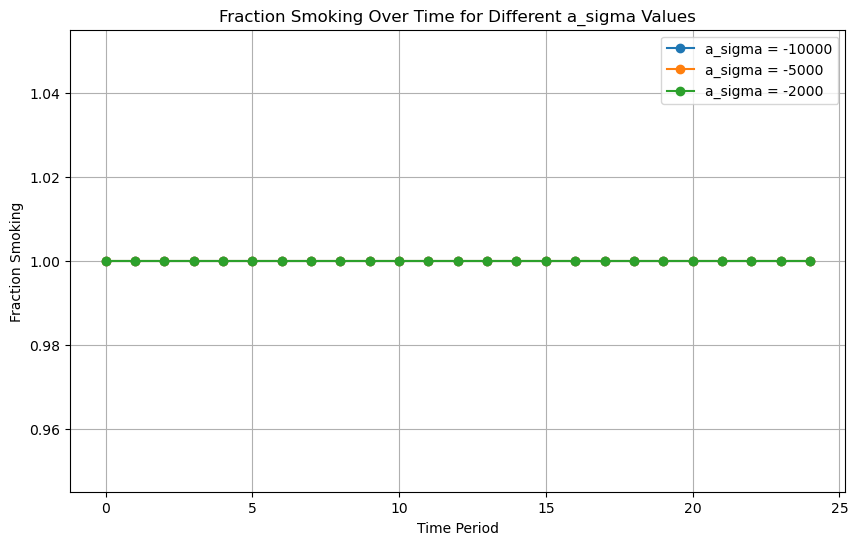

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulation(a_sigma_value, seed=1):
    # ---------------------
    # 1. MODEL PARAMETERS
    # ---------------------
    T = 25             # Number of periods
    delta_S = 0.5         # Depreciation factor for S
    y = 10                # Income (or similar constant)
    p = 1                 # Price or cost parameter for smoking

    # Parameters for the utility function (others remain fixed)
    a_0      = 0.5
    a_c      = 0.6
    a_sb     = 0.21
    a_bsigma = -0.5
    beta     = 0.98       # Discount factor so future matters more
    a_b      = 0.05

    # ---------------------
    # 2. GRIDS
    # ---------------------
    S_grid = np.linspace(0, 50, 50)
    nS = len(S_grid)
    sigma_values = [0, 1]   # sigma grid (binary)
    nSigma = len(sigma_values)
    lambda_grid = np.linspace(-100, 100, 50)
    nLambda = len(lambda_grid)

    # ---------------------
    # 3. CHOICE SET
    # ---------------------
    b_choices = [0, 1]  # 0 = no smoking, 1 = smoking

    # ---------------------
    # 4. UTILITY FUNCTION
    # ---------------------
    # Define a local utility function that depends on the passed a_sigma_value.
    def utility(S, sigma, b):
        return  (a_0 + (y - p * b)**a_c * (1+b)**a_b * (1 + S * b)**a_sb ) - a_sigma_value * sigma # * (1 + sigma * b)**a_bsigma

    # ---------------------
    # 5. TRANSITION FUNCTIONS
    # ---------------------
    def transition_S(S, b):
        # S evolves deterministically
        if b == 1:
            new_S = (1 - delta_S) * S + 1
        else:
            new_S = (1 - delta_S) * S
        new_S = max(new_S, S_grid[0])
        new_S = min(new_S, S_grid[-1])
        return new_S

    def pi_of_S(S, k=0.1, S0=S_grid[-1]/2):
        # Logistic function that maps S to (0,1)
        return 1.0 / (1.0 + np.exp(-k * (S - S0)))

    def transition_lambda(lambda_val, S, sigma_lagged, sigma_current):
        if sigma_lagged == 0:
            if sigma_current == 1:
                new_lambda = lambda_val + np.log(pi_of_S(S) / pi_of_S(0))
            else:
                new_lambda = lambda_val + np.log((1 - pi_of_S(S)) / (1 - pi_of_S(0)))
        else:
            new_lambda = lambda_val
        return new_lambda

    def prob_sigma_next_is_one(sigma_current, lambda_val, S):
        if sigma_current == 1:
            return 1.0
        else:
            num = pi_of_S(S) * np.exp(lambda_val) + pi_of_S(0)
            den = 1.0 + np.exp(lambda_val)
            output = num / den
            return output

    # ---------------------
    # 6. VALUE FUNCTION & POLICY ARRAYS
    # ---------------------
    V = np.zeros((T, nS, nSigma, nLambda))
    Policy = np.zeros((T, nS, nSigma, nLambda), dtype=int)

    # ---------------------
    # 7. BACKWARD INDUCTION
    # ---------------------
    # Last period: immediate utility maximization
    t = T - 1
    for i, S_val in enumerate(S_grid):
        for j, sigma_val in enumerate(sigma_values):
            for k, lambda_val in enumerate(lambda_grid):
                best_value = -np.inf
                best_choice = 0
                for b in b_choices:
                    u = utility(S_val, sigma_val, b)
                    if u > best_value:
                        best_value = u
                        best_choice = b
                V[t, i, j, k] = best_value
                Policy[t, i, j, k] = best_choice

    # Backward induction for earlier periods
    for t in reversed(range(T - 1)):
        for i, S_val in enumerate(S_grid):
            for j, sigma_val in enumerate(sigma_values):
                for k, lambda_val in enumerate(lambda_grid):
                    best_value = -np.inf
                    best_choice = 0
                    for b in b_choices:
                        u = utility(S_val, sigma_val, b)
                        S_next = transition_S(S_val, b)
                        i_next = np.argmin(np.abs(S_grid - S_next))
                        p1 = prob_sigma_next_is_one(sigma_val, lambda_val, S_val)
                        lambda_next_1 = transition_lambda(lambda_val, S_val, sigma_val, 1)
                        k_next_1 = np.argmin(np.abs(lambda_grid - lambda_next_1))
                        lambda_next_0 = transition_lambda(lambda_val, S_val, sigma_val, 0)
                        k_next_0 = np.argmin(np.abs(lambda_grid - lambda_next_0))
                        j_next_1 = 1
                        j_next_0 = 0
                        cont_val = (p1 * V[t+1, i_next, j_next_1, k_next_1] +
                                    (1 - p1) * V[t+1, i_next, j_next_0, k_next_0])
                        total_value = u + beta * cont_val
                        if total_value > best_value:
                            best_value = total_value
                            best_choice = b
                    V[t, i, j, k] = best_value
                    Policy[t, i, j, k] = best_choice

    # ---------------------
    # 8. SIMULATION
    # ---------------------
    P = 100  # Number of individuals
    S_sim = np.zeros((T, P))
    sigma_sim = np.zeros((T, P), dtype=int)
    lambda_sim = np.zeros((T, P))
    b_sim = np.zeros((T, P), dtype=int)

    np.random.seed(seed)
    S_sim[0, :] = 0
    sigma_sim[0, :] = 0
    lambda_sim[0, :] = np.random.choice(lambda_grid, size=P)

    for t in range(T - 1):
        for person in range(P):
            S_val = S_sim[t, person]
            sigma_val = sigma_sim[t, person]
            lambda_val = lambda_sim[t, person]
            i_idx = np.argmin(np.abs(S_grid - S_val))
            j_idx = sigma_values.index(sigma_val)
            k_idx = np.argmin(np.abs(lambda_grid - lambda_val))
            b_decision = Policy[t, i_idx, j_idx, k_idx]
            b_sim[t, person] = b_decision
            S_next = transition_S(S_val, b_decision)
            if sigma_val == 0:
                p1 = pi_of_S(S_val)
            else:
                p1 = 1
            rand = np.random.rand()
            sigma_next = 1 if rand < p1 else 0
            lambda_next = transition_lambda(lambda_val, S_val, sigma_val, sigma_next)
            S_sim[t+1, person] = S_next
            sigma_sim[t+1, person] = sigma_next
            lambda_sim[t+1, person] = lambda_next

    # For the final period decisions.
    for person in range(P):
        i_idx = np.argmin(np.abs(S_grid - S_sim[T-1, person]))
        j_idx = sigma_values.index(sigma_sim[T-1, person])
        k_idx = np.argmin(np.abs(lambda_grid - lambda_sim[T-1, person]))
        b_sim[T-1, person] = Policy[T-1, i_idx, j_idx, k_idx]

    # Compute fraction smoking over time.
    fraction_smoking = np.mean(b_sim, axis=1)
    print(f'a_sigma = {a_sigma_value}')
    return fraction_smoking

# ---------------------
# 9. LOOP OVER a_sigma VALUES AND PLOT
# ---------------------
a_sigma_values = [-10000,-5000,-2000]
results = {}

plt.figure(figsize=(10, 6))
for a_sigma_val in a_sigma_values:
    frac_smoking = run_simulation(a_sigma_val)
    results[a_sigma_val] = frac_smoking
    plt.plot(range(25), frac_smoking, marker='o', label=f'a_sigma = {a_sigma_val}')

plt.xlabel('Time Period')
plt.ylabel('Fraction Smoking')
plt.title('Fraction Smoking Over Time for Different a_sigma Values')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
lambda_set = [-100, -50,0,50, 100]
for p in lambda_set:
    prob = prob_sigma_next_is_one(0, p, 1)
    print(prob)

0.07585818002124355
0.07585818002124355
0.07951543825758295
0.08317269649392235
0.08317269649392235


# Test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Assuming Policy, S_grid, lambda_grid, and sigma_values are defined from the previous code.
# Here, t0=0 and we consider sigma=0.
t0 = 24
sigma0_index = sigma_values.index(0)

# Create a 2D array to store the optimal decision for each (S, lambda) combination.
decision_grid = np.zeros((len(S_grid), len(lambda_grid)))

# Loop over all grid points for S and lambda.
for i, S_val in enumerate(S_grid):
    for k, lambda_val in enumerate(lambda_grid):
        decision_grid[i, k] = Policy[t0, i, sigma0_index, k]

# Define a discrete colormap with two colors.
# For example, blue for b=0 (no smoking) and red for b=1 (smoking).
cmap = ListedColormap(['blue', 'red'])
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot the decision grid using a heatmap.
plt.figure(figsize=(8, 6))
img = plt.imshow(decision_grid, extent=[lambda_grid[0], lambda_grid[-1], S_grid[0], S_grid[-1]],
           aspect='auto', origin='lower', cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ticks=[0, 1])
cbar.ax.set_yticklabels(['No Smoking (b=0)', 'Smoking (b=1)'])
plt.xlabel('lambda')
plt.ylabel('S')
plt.title('Optimal Decision at t=0 for sigma=0')
plt.show()


# Simulkate

In [ ]:
P = 100  # Number of simulated persons

# Arrays to store simulated state trajectories
S_sim = np.zeros((T, P))
sigma_sim = np.zeros((T, P), dtype=int)
lambda_sim = np.zeros((T, P))
b_sim = np.zeros((T, P), dtype=int)  # Decision at each period

# Initialize individuals: randomly sample initial S and lambda; sigma set to 0.
np.random.seed(1)
S_sim[0, :] = 0 # np.random.choice(S_grid, size=P)
sigma_sim[0, :] = 0
lambda_sim[0, :] = np.random.choice(lambda_grid, size=P)

# Simulate forward in time.
for t in range(T - 1):
    for person in range(P):
        # Current state
        S_val = S_sim[t, person]
        sigma_val = sigma_sim[t, person]
        lambda_val = lambda_sim[t, person]
        
        # Find nearest grid indices.
        i_idx = np.argmin(np.abs(S_grid - S_val))
        j_idx = sigma_values.index(sigma_val)
        k_idx = np.argmin(np.abs(lambda_grid - lambda_val))
        
        # Retrieve optimal decision from the pre-computed policy.
        b_decision = Policy[t, i_idx, j_idx, k_idx]
        b_sim[t, person] = b_decision
        
        # Update state for S.
        S_next = transition_S(S_val, b_decision)
        
        # Update sigma: if sigma is already 1, it remains 1; if 0, sample based on probability.
        p1 = prob_sigma_next_is_one(sigma_val, lambda_val, S_val) if sigma_val == 0 else 1.0
        sigma_next = 1 if np.random.rand() < p1 else 0
        
        # Update lambda based on the belief update.
        lambda_next = transition_lambda(lambda_val, S_val, sigma_val, sigma_next)
        
        # Store new states for t+1.
        S_sim[t+1, person] = S_next
        sigma_sim[t+1, person] = sigma_next
        lambda_sim[t+1, person] = lambda_next

# Store the final period's decision as well.
for person in range(P):
    i_idx = np.argmin(np.abs(S_grid - S_sim[T-1, person]))
    j_idx = sigma_values.index(sigma_sim[T-1, person])
    k_idx = np.argmin(np.abs(lambda_grid - lambda_sim[T-1, person]))
    b_sim[T-1, person] = Policy[T-1, i_idx, j_idx, k_idx]

# ---------------------
# 8. PLOTTING SIMULATION RESULTS
# ---------------------
# For example, plot the fraction of persons smoking over time.
fraction_smoking = np.mean(b_sim, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(range(T), fraction_smoking, marker='o')
plt.xlabel('Time Period')
plt.ylabel('Fraction Smoking')
plt.title('Simulated Fraction of Persons Who Smoke Over Time')
plt.grid(True)
plt.show()

# Also, we can plot average lambda over time.
avg_lambda = np.mean(lambda_sim, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(range(T), avg_lambda, marker='o', color='orange')
plt.xlabel('Time Period')
plt.ylabel('Average lambda')
plt.title('Average Belief (lambda) Over Time')
plt.grid(True)
plt.show()

# Compute fraction of sick persons (sigma == 1) over time.
fraction_sick = np.mean(sigma_sim, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(range(T), fraction_sick, marker='o', color='red')
plt.xlabel('Time Period')
plt.ylabel('Fraction Sick (σ=1)')
plt.title('Simulated Fraction of Persons Who Are Sick Over Time')
plt.grid(True)
plt.show()